### Your name:

<pre> Maryam Mohseni </pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data available contains 370 time series, corresponding to the electric demand for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
pathToFile = r"./Data/"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

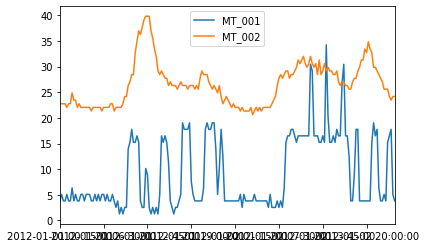

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand.

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # Clients with 0 demand
data_13_14 = data2013.append(data2014) # Appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # Drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # Check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # Weekdays weekends, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [19]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

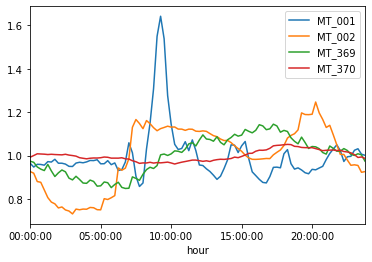

In [20]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [21]:
X = average_curves_norm.copy()
X = np.array(X.T) # Put it on the right format

## Exercise 1:

a. Using the functions described in Module 4, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [22]:
random.seed(42)
# Part a.
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # This is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2

# Computing 3 performance measures for a range of values of 𝑘
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 20
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]        

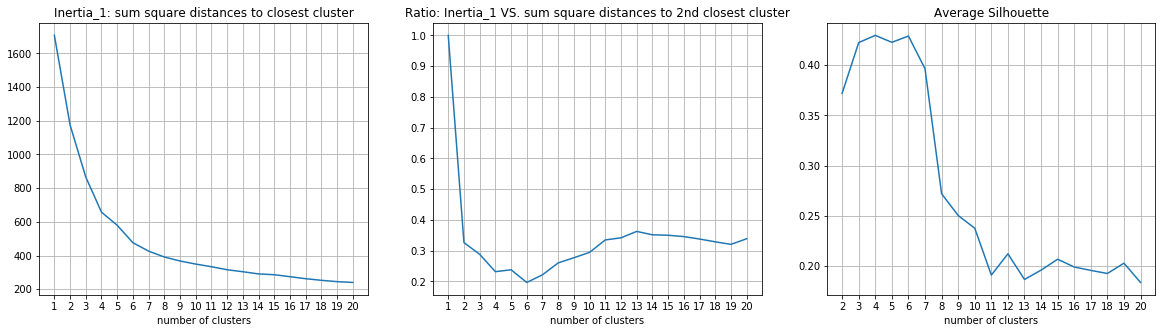

In [23]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

Explanations:
I think the best value for number of clusters is 6, because we are 
interested in the minimum value for inertia_1 (left figure) and also minimum value for intertia_1/intertia_2 (middle figure) and also maximum value for silhouette (right figure). Actually we are looking at elbow for inertai_1 as it is obvious that decreases with number of cluster. The minimum intertia_1/intertia_2 and maximum silhouette happens at K=6.

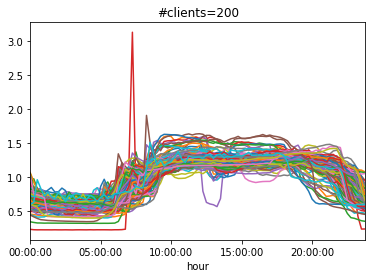

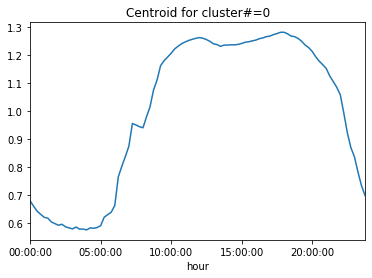

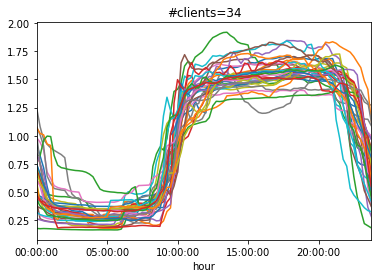

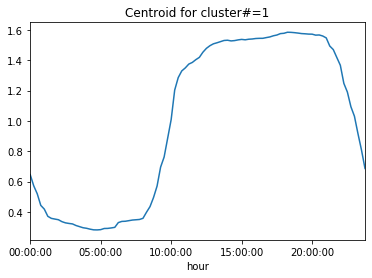

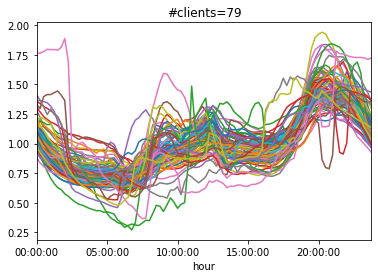

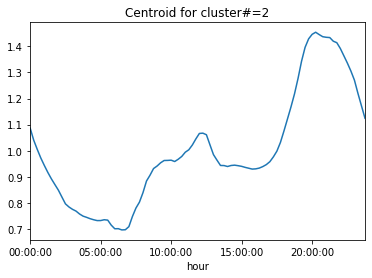

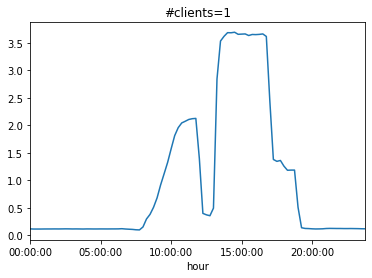

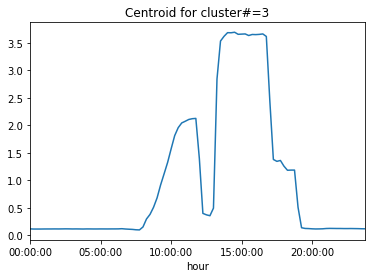

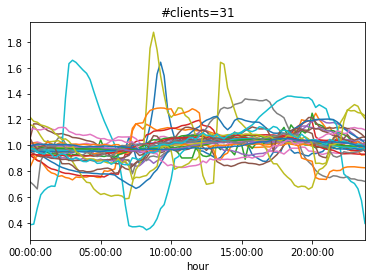

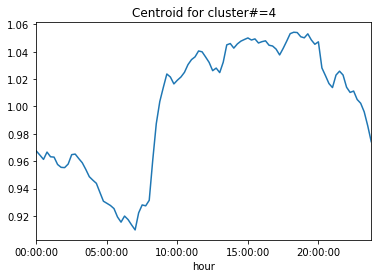

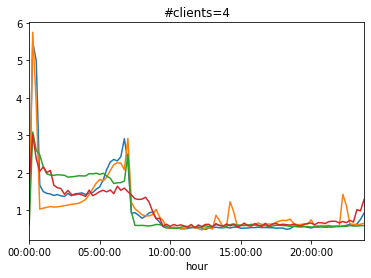

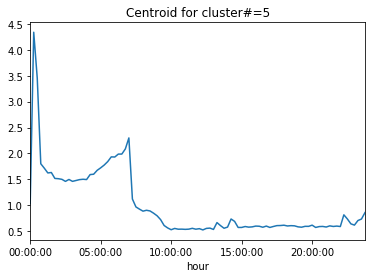

In [24]:
# Part b.
from itertools import compress
k=6
kmeans = KMeans(n_clusters=k, random_state=0).fit(X) 

L=average_curves_norm.columns
for J in range(k):

    X_J = X[kmeans.labels_==J]
    
    B=kmeans.labels_==J
    average_curves_norm[list(compress(L, B))].plot(legend=None)
    plt.title('#clients=%i' % X_J.shape[0])
    
    plt.show()
    
    M=average_curves_norm[list(compress(L, B))].copy()
    M=M.T
    M=M.mean()
    M=M.T
    M.plot()
    plt.title('Centroid for cluster#=%i' % J)
    plt.show()

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [25]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # A list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [26]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # Start date
d2 = date(2014, 12, 31)  # End date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for part (b)

In [27]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

## Solution to Exercise 2

In [28]:
# Part a.
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # A list of arrays, each array being a normalized curve for a day

XX=np.zeros([1,96])
# print(XX.shape)

for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])/np.mean(oneClient[J*96:(J+1)*96])])
    XX = np.append(XX,[np.array(oneClient[J*96:(J+1)*96])], axis=0) # single array
XX=np.delete(XX,0,0)
print(XX.shape)

(730, 96)


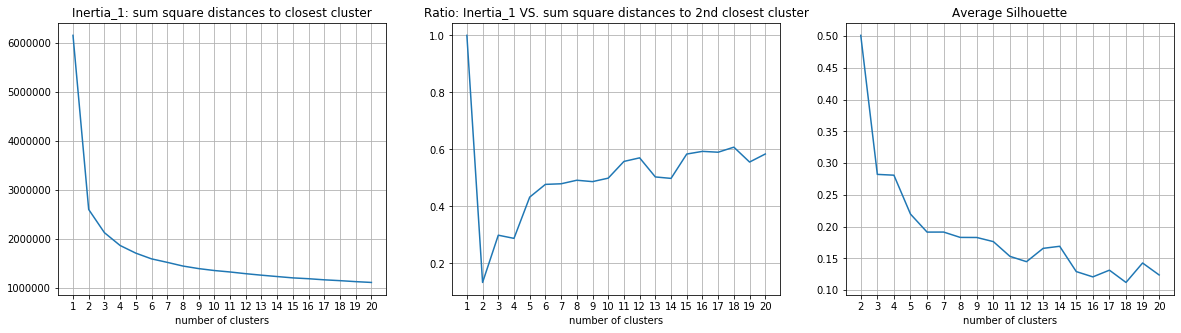

In [29]:
# Computing 3 performance measures for a range of values of 𝑘
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 20
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(XX)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(XX,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(XX, kmeans.labels_)]        
# plot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

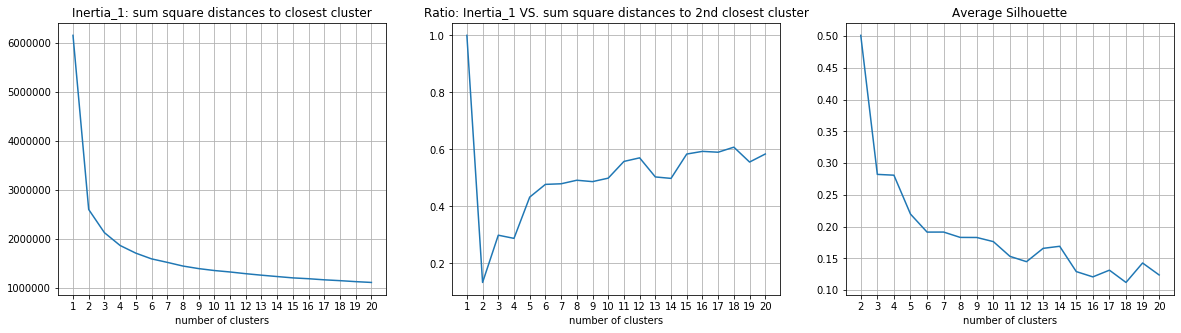

In [30]:
# Computing 3 performance measures for a range of values of 𝑘
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 20
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(XX)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(XX,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(XX, kmeans.labels_)]        
# plot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

Explanations:
I think the best value for number of clusters is 2, because we are 
interested in the minimum value for inertia_1 (left figure) and also minimum value for intertia_1/intertia_2 (middle figure) and also maximum value for silhouette (right figure). Actually we are looking at elbow for inertai_1 as it is obvious that decreases with number of cluster. The minimum intertia_1/intertia_2 and maximum silhouette happens at K=2.

['tue-2013-01-01', 'sat-2013-01-05', 'sun-2013-01-06', 'sat-2013-01-12', 'sun-2013-01-13', 'sat-2013-01-19', 'sun-2013-01-20', 'sat-2013-01-26', 'sun-2013-01-27', 'sat-2013-02-02', 'sun-2013-02-03', 'sat-2013-02-09', 'sun-2013-02-10', 'tue-2013-02-12', 'sat-2013-02-16', 'sun-2013-02-17', 'sat-2013-02-23', 'sun-2013-02-24', 'sat-2013-03-02', 'sun-2013-03-03', 'sat-2013-03-09', 'sun-2013-03-10', 'sat-2013-03-16', 'sun-2013-03-17', 'sat-2013-03-23', 'sun-2013-03-24', 'fri-2013-03-29', 'sat-2013-03-30', 'sun-2013-03-31', 'mon-2013-04-01', 'sat-2013-04-06', 'sun-2013-04-07', 'sat-2013-04-13', 'sun-2013-04-14', 'sat-2013-04-20', 'sun-2013-04-21', 'thu-2013-04-25', 'sat-2013-04-27', 'sun-2013-04-28', 'wed-2013-05-01', 'thu-2013-05-02', 'fri-2013-05-03', 'sat-2013-05-04', 'sun-2013-05-05', 'sat-2013-05-11', 'sun-2013-05-12', 'sat-2013-05-18', 'sun-2013-05-19', 'sat-2013-05-25', 'sun-2013-05-26', 'sat-2013-06-01', 'sun-2013-06-02', 'sat-2013-06-08', 'sun-2013-06-09', 'mon-2013-06-10', 'sat-2013

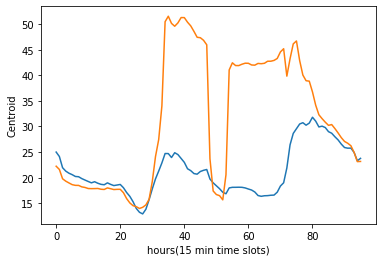

In [31]:
# Part b.
from itertools import compress
k=2
kmeans = KMeans(n_clusters=k, random_state=0).fit(XX) 
NumDays=[];

from datetime import date, timedelta

d1 = date(2013, 1, 1)  # Start date
d2 = date(2014, 12, 31)  # End date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])
#daysyear

for J in range(k):

    XX_J = XX[kmeans.labels_==J]
    NumDays=NumDays+[XX_J.shape[0]]
    
    B=kmeans.labels_==J
    print(list(compress(daysyear, B)))
    
print(NumDays)
print(kmeans.cluster_centers_)
plt.plot(kmeans.cluster_centers_[0])
plt.plot(kmeans.cluster_centers_[1])
plt.ylabel('Centroid')
plt.xlabel('hours(15 min time slots)')
plt.show()

Explanations:
With K=2, each day in a year is either in a cluser 0 or cluster 1 based on the resulting labels. NumDays shows that 219 instances (days) are in the first cluster (cluster#=0) and the remaining 511 instances are clustered in the second cluster (cluster#=1). For each of this cluster we printed the instances (days) in that cluster. As we see mainly they are clustered based on weekdays and weekends. The resaon is that most of the days in the first cluster are sat and sun. However, most of the weekdays e.g mon, tue, wed, thu, and fri are in the second cluster which makes sense with the 219 and 511 ((730*2)/7=208.5 and (730*5)/7=512.4 which are the ideal expected days in each cluster). So it means each cluster represents either weekdays or weekends. We also plotted the centroid for both clusters and the blue one is for weekend and the orange one is for weekdays. As we see on average, the electric demand during weekdays is higher than weekends (per day).